In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-white")

import random
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm

from data import PermutedMNIST
from utils import EWC, ewc_train, normal_train, test
import pickle 
from vae import VAE
import utils_vae
import numpy as np
from operator import itemgetter

In [2]:
epochs = 30
lr = 1e-3
batch_size = 128
sample_size = 200
hidden_size = 400
num_task = 3

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
lambda_val = 0.005
vae_lr=0.000035

In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_size=400):
        super(MLP, self).__init__()
        self.input_dropout = nn.Dropout(p=0.2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(28 * 28, hidden_size, bias=False)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc3 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu((self.fc1(input)))
        x = F.relu((self.fc2(x)))
        x = F.relu((self.fc3(x)))
        x = F.relu(self.fc4(x))
        return x


In [4]:
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx), batch_size=batch_size,num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()


In [5]:
def standard_process(epochs, use_cuda=True, weight=True):
    model = MLP(hidden_size)

    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc, li_class_matrix = {}, {}, {0:[], 1:[], 2:[]}
    for task in tqdm(range(num_task)):
        loss[task] = []
        acc[task] = []
        for _ in (range(epochs)):
            loss[task].append(normal_train(model, optimizer, train_loader[task]))
            for sub_task in range(task + 1):
                acc_, class_matrix =  test(model, test_loader[sub_task])
                acc[sub_task].append(acc_)
                li_class_matrix[sub_task].append(class_matrix)
        if task == 0 and weight:
            weight = model.state_dict()
    return loss, acc, weight, li_class_matrix


def ewc_process(epochs, importance, sample_size=sample_size,use_cuda=True, weight=None):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc, li_class_matrix = {}, {}, {0:[], 1:[], 2:[]}
    for task in tqdm(range(num_task)):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in (range(epochs)):
                    loss[task].append(normal_train(model, optimizer, train_loader[task]))
                    acc_, class_matrix =  test(model, test_loader[task])
                    acc[task].append(acc_)
                    li_class_matrix[task].append(class_matrix)
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for _ in (range(epochs)):
                loss[task].append(ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance))
                for sub_task in range(task + 1):
                    acc_, class_matrix =  test(model, test_loader[sub_task])
                    acc[sub_task].append(acc_)
                    li_class_matrix[sub_task].append(class_matrix)
    weights = model.state_dict()
    return loss, acc, weights, li_class_matrix

def create_vae(lambda_val=lambda_val,num_inputs=20):
    return VAE(num_inputs, 18, num_task, 12, lambda_val).to(device)

def vae_ewc_process(epochs,importance,lambda_val_=lambda_val,vlr=vae_lr,sample_size=sample_size,use_cuda=True,weight=None):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)          

    loss, acc, li_class_matrix = {}, {}, {0:[], 1:[], 2:[]}
    vae_loss = []
    for task in tqdm(range(num_task)):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in (range(epochs)):
                    loss[task].append(normal_train(model, optimizer, train_loader[task]))
                    acc_, class_matrix =  test(model, test_loader[task])
                    acc[task].append(acc_)
                    li_class_matrix[task].append(class_matrix)
        else:
            old_tasks = []
            old_task_labels = []
            for sub_task in range(task):
                updated_old_tasks = train_loader[sub_task].dataset.get_sample(sample_size)
                old_tasks = old_tasks + updated_old_tasks
                old_task_labels.extend([task for _ in range(sample_size)])
            idxs = sorted(np.random.choice(np.arange(len(old_tasks)), size=sample_size, replace=False))
            old_tasks = itemgetter(*idxs)(old_tasks)
            old_task_labels = itemgetter(*idxs)(old_task_labels)

            vae = create_vae(lambda_val_)
            vae_optim = optim.Adam(params=vae.parameters(), lr=vlr)
            ewc = utils_vae.EWC(model, old_tasks, old_task_labels, vae)
            vae_loss = ewc.train_vae(vae, vae_optim, input_size=20)
            for _ in (range(epochs)):
                loss[task].append(utils_vae.vae_ewc_train(model, optimizer, train_loader[task], utils_vae.EWC(model, old_tasks,old_task_labels, vae), importance))
                for sub_task in range(task + 1):
                    acc_, class_matrix =  test(model, test_loader[sub_task])
                    acc[sub_task].append(acc_)
                    li_class_matrix[sub_task].append(class_matrix)
    retro_acc = [] 
    # for subtask in range(task+1):
    #     retro_acc.append(test(model, test_loader[subtask]))
    weights = model.state_dict()
    vae_weights = vae.state_dict()
    return loss, acc, retro_acc, vae_loss, weights, vae_weights, li_class_matrix

In [6]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v)
    plt.ylim(0, 1)

In [7]:
loss, acc, weight, li_class_matrix = standard_process(epochs)

  0%|          | 0/3 [00:29<?, ?it/s]


KeyboardInterrupt: 

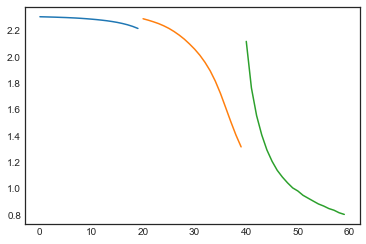

In [26]:
loss_plot(loss)

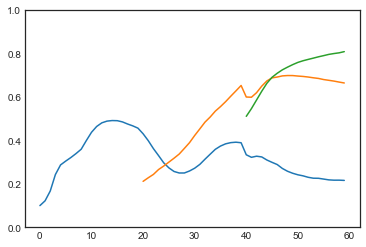

In [27]:
accuracy_plot(acc)

In [15]:
samples_ = 100

samples_li = [200,200,200,200,200,200,200]
vae_lr = [0.0000035,0.0000035,0.0000035,0.0000035,0.0000035,0.000035,0.00035]
lambdas = [0.05, 0.0005,0.005,0.0005,0.005,0.005,0.005]
importance_ = [1000,50,100,10000,10000,10000,10000]

for i in range(0, 2, 1):
    
   for idx in range(len(importance_)):
      vae_loss_fixed, vae_acc_fixed, _, vae_net_loss_fixed, weights, vae_weights,li_class_matrix = vae_ewc_process(epochs, importance=importance_[idx], lambda_val_ = lambdas[idx], vlr=vae_lr[idx],sample_size=samples_li[idx])
      with open("final_runs/final_grid_search/30_EPOCH_VAE_FIXED_SAMPLE_%d_VAE_LR_%.8f_LAMBDA_%.5f_IMPORTANCE_%d_RUN_%d" % (samples_li[idx], vae_lr[idx], lambdas[idx], importance_[idx], i), 'wb') as f:
         data = {'loss':vae_loss_fixed,'acc':vae_acc_fixed, 'weights':weights, 'vae_weights':vae_weights, 'vae_net_loss':vae_net_loss_fixed, 'class_matrix':li_class_matrix}
         pickle.dump(data, f)
      torch.save(weights, 'final_runs/final_grid_search/30_EPOCH_VAE_FIXED_SAMPLE_%d_VAE_LR_%.8f_LAMBDA_%.5f_IMPORTANCE_%d_RUN_%d_MLP_WEIGHTS'% (samples_li[idx], vae_lr[idx], lambdas[idx], importance_[idx], i))
      torch.save(vae_weights, 'final_runs/final_grid_search/30_EPOCH_VAE_FIXED_SAMPLE_%d_VAE_LR_%.8f_LAMBDA_%.5f_IMPORTANCE_%d_RUN_%d_VAE_WEIGHTS'% (samples_li[idx], vae_lr[idx], lambdas[idx], importance_[idx], i))



100%|██████████| 3/3 [11:27<00:00, 229.01s/it]


In [9]:
samples_ = 200
imp0 = 100
imp1 = 1000
lambda0 = 0.05
lambda1 = 0.05
vlr0 = 0.00035
vlr1 = 0.000035

vlr_FIXED = 0.0000035
imp_FIXED = 1000
lambda_FIXED = 0.05
samples_FIXED = 200

vlr_FIXED2 = 0.0000035
imp_FIXED2 = 10000
lambda_FIXED2 = 0.0005
samples_FIXED2 = 200
for i in range(7, 9, 1):

   vae_loss_fixed2, vae_acc_fixed2, _, vae_net_loss_fixed2, weights, vae_weights,li_class_matrix = vae_ewc_process(epochs, importance=imp_FIXED2, lambda_val_ = lambda_FIXED2, vlr=vlr_FIXED2,sample_size=samples_FIXED2)
   with open("Evaluation Data/results2/30_EPOCH_VAE2_FIXED"+str(i), 'wb') as f:
      data = {'loss':vae_loss_fixed2,'acc':vae_acc_fixed2, 'weights':weights, 'vae_weights':vae_weights, 'vae_net_loss':vae_net_loss_fixed2, 'class_matrix':li_class_matrix}
      pickle.dump(data, f)
   torch.save(weights, 'Evaluation Data/30_EPOCH_VAE2_FIXED'+str(i)+"MLP_WEIGHTS")
   torch.save(vae_weights, 'Evaluation Data/30_EPOCH_VAE2_FIXED'+str(i)+"VAE_WEIGHTS")   


   loss, acc, weight, li_class_matrix = standard_process(epochs)
   with open("Evaluation Data/results/30_EPOCH_STANDARD"+str(i), 'wb') as f:
      data = {'loss':loss, 'acc':acc, 'weight':weight, 'class_matrix':li_class_matrix}
      pickle.dump(data, f)
   torch.save(weight, 'Evaluation Data/30_EPOCH_VAE_FIXED_StandardProcess_'+str(i)+"MLP_WEIGHTS")


   
   loss_ewc, acc_ewc, weights,li_class_matrix = ewc_process(epochs, importance=1000, sample_size=200,                                            
                                          )
   with open("Evaluation Data/results/30_EPOCH_EWC"+str(i), 'wb') as f:
      data = {'loss_ewc':loss_ewc,'acc_ewc':acc_ewc,'class_matrix':li_class_matrix}
      pickle.dump(data, f)
   torch.save(weights, 'Evaluation Data/30_EPOCH_VAE_FIXED_EWC_'+str(i)+"MLP_WEIGHTS")
   
   # vae_loss_fixed, vae_acc_fixed, _, vae_net_loss_fixed, weights, vae_weights,li_class_matrix = vae_ewc_process(epochs, importance=imp_FIXED, lambda_val_ = lambda_FIXED, vlr=vlr_FIXED,sample_size=samples_FIXED)
   # with open("Evaluation Data/results2/30_EPOCH_VAE_FIXED"+str(i), 'wb') as f:
   #    data = {'loss':vae_loss_fixed,'acc':vae_acc_fixed, 'weights':weights, 'vae_weights':vae_weights, 'vae_net_loss':vae_net_loss_fixed, 'class_matrix':li_class_matrix}
   #    pickle.dump(data, f)
   # torch.save(weights, 'Evaluation Data/30_EPOCH_VAE_FIXED'+str(i)+"MLP_WEIGHTS")
   # torch.save(vae_weights, 'Evaluation Data/30_EPOCH_VAE_FIXED'+str(i)+"VAE_WEIGHTS")   



100%|██████████| 3/3 [09:44<00:00, 194.94s/it]


In [7]:
samples = [200]
vae_lr = [0.0000035,0.000035,0.00035]
lambda_vals = [0.0005, 0.005, 0.05]
importances = [50,100,1000,10000]
for run in range(0,3,1):
    for ss in samples:
        for imp in importances:
            for vlr in vae_lr:
                for lmr in lambda_vals:   
                    vae_loss, vae_acc, _, vae_net_loss,_,_,_ = vae_ewc_process(epochs, importance=imp, lambda_val_ = lmr, vlr=vlr,sample_size=ss)
                    name = "final_runs/last_data/Runlog_loss_no_bias_GRIDSEARCH_SAMPLES_%d_vae_lr_%.10f_lambda_%.5f_Importance_%d_run_%d" % (ss, vlr,lmr, imp, run)
                    with open(name, "wb") as f:
                        data = {"vae_loss":vae_loss, "vae_acc":vae_acc, "vae_network_loss":vae_net_loss}
                        pickle.dump(data,f)


 67%|██████▋   | 2/3 [10:41<05:20, 320.54s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(vae_loss)

In [ ]:
loss_plot(loss_ewc)

In [ ]:
accuracy_plot(acc_ewc)


In [ ]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.plot(vae_acc[0], label="Vae")
plt.plot(vae_acc2[0], label="Vae2")
plt.plot(vae_acc3[0], label="Vae3")
plt.legend()

In [ ]:
plt.plot(acc[1], label="sgd")
plt.plot(acc_ewc[1], label="ewc")
plt.plot(vae_acc[1], label="Vae")
plt.plot(vae_acc2[1], label="Vae2")
plt.plot(vae_acc3[1], label="Vae3")
plt.legend()

In [ ]:
plt.plot(acc[2], label="sgd")
plt.plot(acc_ewc[2], label="ewc")
plt.plot(vae_acc[2], label="Vae")
plt.plot(vae_acc2[2], label="Vae2")
plt.plot(vae_acc3[2], label="Vae3")
plt.legend()